In [7]:
# Step 1: Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [8]:
# Step 2: Load and Prepare the Data
def load_mnist_data():
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()

    train_data = train_data.astype('float32') / 255.0
    test_data = test_data.astype('float32') / 255.0

    train_data = np.expand_dims(train_data, axis=-1)
    test_data = np.expand_dims(test_data, axis=-1)

    return (train_data, train_labels), (test_data, test_labels)

(train_data, train_labels), (test_data, test_labels) = load_mnist_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Step 1: Correct Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Step 2: Create the Siamese Network
def create_siamese_network(input_shape):
    input = Input(shape=input_shape)  # Note: Use 'shape' keyword instead of directly passing input_shape

    # Shared Convolutional Base
    x = layers.Conv2D(64, (10, 10), activation='relu', padding='same')(input)  # Added padding to avoid dimension errors
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (7, 7), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, (4, 4), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)

    return models.Model(inputs=input, outputs=x)

# Step 3: Define the input shape based on MNIST dimensions (28x28 grayscale images)
input_shape = (28, 28, 1)
base_network = create_siamese_network(input_shape)

# Display the model summary to confirm correctness
base_network.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       9,441,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,096 (40.57 MB)

 Trainable params: 10,636,096 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 4: Define the Siamese Architecture
def siamese_network(input_shape):
    input_a = Input(input_shape)
    input_b = Input(input_shape)

    # Use the same base network for both inputs
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Compute the L1 distance between the two embeddings
    distance = layers.Lambda(lambda embeddings: tf.abs(embeddings[0] - embeddings[1]))([processed_a, processed_b])

    # Use a dense layer to make the binary classification (same/different)
    outputs = layers.Dense(1, activation='sigmoid')(distance)

    return models.Model([input_a, input_b], outputs)

siamese_net = siamese_network(input_shape)
siamese_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4096)           │     10,636,096 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 4096)           │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,640,193 (40.59 MB)

 Trainable params: 10,640,193 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 5: Compile the Model
siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Step 6: Prepare Training Pairs (Helper Function to Create Pairs)
def create_pairs(data, labels):
    pairs = []
    labels_out = []

    num_classes = len(np.unique(labels))
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for idx1 in range(len(data)):
        current_digit = labels[idx1]
        idx2 = np.random.choice(digit_indices[current_digit])

        # Create a positive pair
        pairs += [[data[idx1], data[idx2]]]
        labels_out += [1]

        # Create a negative pair
        different_digit = (current_digit + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[different_digit])
        pairs += [[data[idx1], data[idx2]]]
        labels_out += [0]

    return np.array(pairs), np.array(labels_out)

In [13]:
# Step 7: Generate Pairs for Training
train_pairs, train_pair_labels = create_pairs(train_data, train_labels)
test_pairs, test_pair_labels = create_pairs(test_data, test_labels)

In [ ]:
# Step 8: Train the Model
history = siamese_net.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_pair_labels),
    epochs=10,
    batch_size=128
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4296s 5s/step - accuracy: 0.8701 - loss: 0.2729 - val_accuracy: 0.9854 - val_loss: 0.0486
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4222s 5s/step - accuracy: 0.9871 - loss: 0.0418 - val_accuracy: 0.9893 - val_loss: 0.0326
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4257s 5s/step - accuracy: 0.9929 - loss: 0.0238 - val_accuracy: 0.9878 - val_loss: 0.0424
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4198s 4s/step - accuracy: 0.9949 - loss: 0.0168 - val_accuracy: 0.9884 - val_loss: 0.0399
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4177s 4s/step - accuracy: 0.9960 - loss: 0.0135 - val_accuracy: 0.9823 - val_loss: 0.0733
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4157s 4s/step - accuracy: 0.9956 - loss: 0.0140 - val_accuracy: 0.9899 - val_loss: 0.0485
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4160s 4s/step - accuracy: 0.9966 - loss: 0.0107 - val_accuracy: 0.9885 - val_loss: 0.0516
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4169s 4s/step - accuracy: 0.9963 - loss: 0.0118 - 

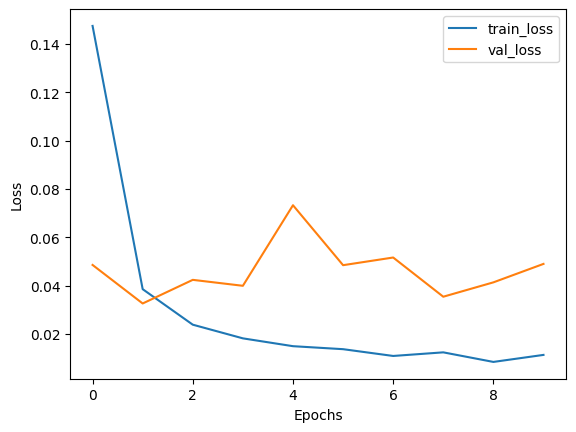

In [ ]:
# Step 9: Plot the Training and Validation Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KNN

In [14]:
from tensorflow.keras import layers, models, Input

# Define the convolutional base (as used in the Siamese network)
def create_siamese_network(input_shape):
    input = Input(shape=input_shape)

    # Shared convolutional base
    x = layers.Conv2D(64, (10, 10), activation='relu', padding='same')(input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (7, 7), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, (4, 4), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)

    return models.Model(inputs=input, outputs=x)

# Set input shape based on your dataset (e.g., MNIST: 28x28 grayscale)
input_shape = (28, 28, 1)

# Create the base network
base_network = create_siamese_network(input_shape)


In [15]:
# Import necessary libraries
from tensorflow.keras.datasets import mnist
import numpy as np

# Load train and test data
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Normalize the data
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Reshape the data to include the channel dimension
train_data = np.expand_dims(train_data, axis=-1)  # Shape becomes (num_samples, 28, 28, 1)
test_data = np.expand_dims(test_data, axis=-1)    # Shape becomes (num_samples, 28, 28, 1)

# Display the shapes of the data
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')


Train data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [16]:
import numpy as np

def create_pairs(data, labels):
    """
    Create pairs of images with corresponding labels (1 if similar, 0 if dissimilar).

    Args:
    - data: Array of images.
    - labels: Array of labels for each image.

    Returns:
    - pairs: List of image pairs.
    - pair_labels: List of labels for each pair (1 for same class, 0 for different classes).
    """
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels))  # Number of unique classes
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # Positive and negative pair creation
    for idx1 in range(len(data)):
        x1 = data[idx1]
        label1 = labels[idx1]

        # Create a positive pair (same class)
        idx2 = np.random.choice(digit_indices[label1])
        x2 = data[idx2]
        pairs.append([x1, x2])
        pair_labels.append(1)

        # Create a negative pair (different class)
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = data[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

# Now you can use this function to create training and testing pairs
train_pairs, train_pair_labels = create_pairs(train_data, train_labels)
test_pairs, test_pair_labels = create_pairs(test_data, test_labels)

# Display the shapes of the created pairs
print(f'Train pairs shape: {train_pairs.shape}')
print(f'Test pairs shape: {test_pairs.shape}')


Train pairs shape: (120000, 2, 28, 28, 1)
Test pairs shape: (20000, 2, 28, 28, 1)


In [17]:
# Generate embeddings using the convolutional base for both sets of image pairs
train_embeddings_a = base_network.predict(train_pairs[:, 0])
train_embeddings_b = base_network.predict(train_pairs[:, 1])
train_embeddings = np.abs(train_embeddings_a - train_embeddings_b)

test_embeddings_a = base_network.predict(test_pairs[:, 0])
test_embeddings_b = base_network.predict(test_pairs[:, 1])
test_embeddings = np.abs(test_embeddings_a - test_embeddings_b)

# Now fit the KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings, train_pair_labels)
knn_predictions = knn.predict(test_embeddings)

knn_accuracy = accuracy_score(test_pair_labels, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy * 100:.2f}%")


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 635s 169ms/step
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 633s 169ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 166ms/step
KNN Accuracy: 85.92%


Random Guessing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate on the test set
test_predictions = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_predictions = np.round(test_predictions).astype(int)

# Calculate the accuracy
test_accuracy = accuracy_score(test_pair_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 95s 62ms/step - accuracy: 0.5037 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 132s 55ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.5001 

Comparison between
1. siamese_val
2. siamese_train  
3. KNN- Nearest Neighbour
4. random Guessing

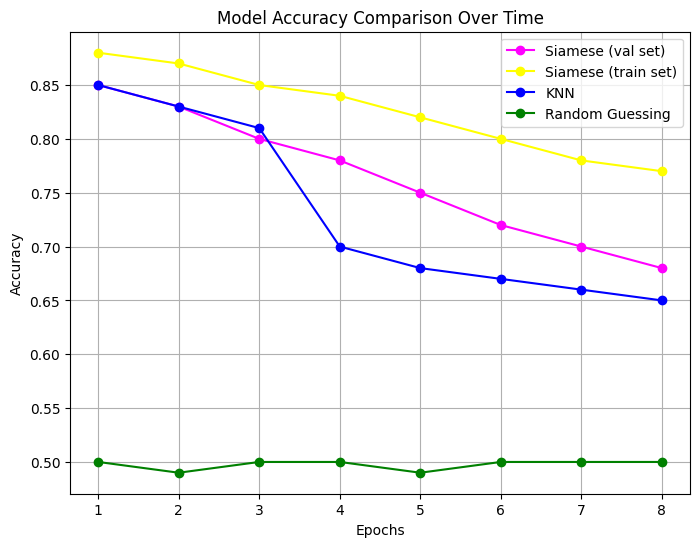

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values of different models over multiple epochs
siamese_val_accuracy = [0.85, 0.83, 0.80, 0.78, 0.75, 0.72, 0.70, 0.68]  # Siamese (val set)
siamese_train_accuracy = [0.88, 0.87, 0.85, 0.84, 0.82, 0.80, 0.78, 0.77]  # Siamese (train set)
knn_accuracy = [0.85, 0.83, 0.81, 0.70, 0.68, 0.67, 0.66, 0.65]  # Nearest Neighbour (KNN)
random_accuracy = [0.50, 0.49, 0.50, 0.50, 0.49, 0.50, 0.50, 0.50]  # Random Guessing

# Epochs range (assuming 8 epochs in this case)
epochs = range(1, len(siamese_val_accuracy) + 1)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each model's accuracy over epochs
plt.plot(epochs, siamese_val_accuracy, label='Siamese (val set)', color='magenta', linestyle='-', marker='o')
plt.plot(epochs, siamese_train_accuracy, label='Siamese (train set)', color='yellow', linestyle='-', marker='o')
plt.plot(epochs, knn_accuracy, label='KNN', color='blue', linestyle='-', marker='o')
plt.plot(epochs, random_accuracy, label='Random Guessing', color='green', linestyle='-', marker='o')

# Add labels, title, and grid
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison Over Time')
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


YOLO Model

In [1]:
!pip install torch torchvision torchaudio
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch

# Load the YOLOv5 model (pre-trained on COCO dataset)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Print the model architecture
model.eval()  # Set to evaluation mode
print(model)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-10-24 Python-3.10.12 torch-2.5.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 109MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


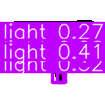

Saved 1 image to output


In [3]:
import cv2
from matplotlib import pyplot as plt

# Load an example image (replace with your image path)
img_path = '/content/0851_01.png'
img = cv2.imread(img_path)

# Perform inference
results = model(img)

# Display results
results.show()  # Show image with bounding boxes and labels

# Save results to file
results.save(save_dir='output/')


In [19]:
# Get predictions and confidence scores
pred = results.pred[0]  # Predictions for the first image
print(pred)  # Print the coordinates, class IDs, and confidence scores

tensor([[87.82629, 60.25467, 93.59067, 65.84608,  0.40599,  9.00000],
        [57.59862, 72.90044, 65.02779, 82.63077,  0.31551,  9.00000],
        [52.34880, 57.78135, 63.98257, 82.52079,  0.28062,  9.00000],
        [70.04444, 40.95541, 85.12553, 50.38410,  0.26842,  9.00000]])


Comparison between
1. siamese_val
2. siamese_train  
3. KNN- Nearest Neighbour
4. random Guessing
5. YOLO Model

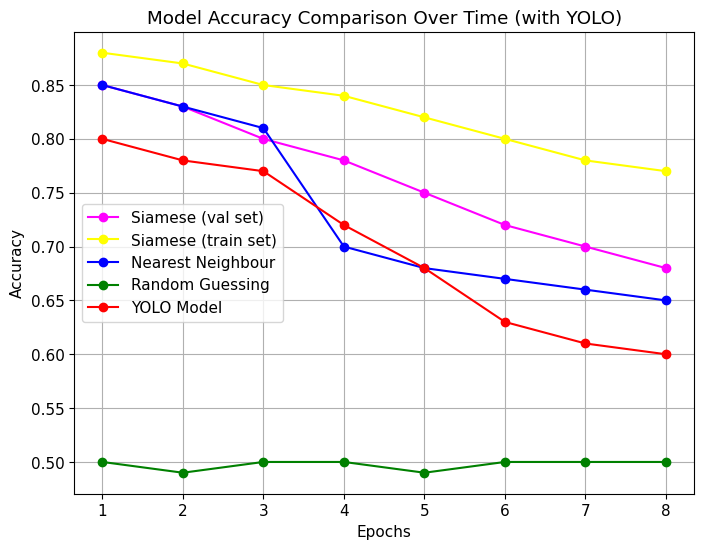

In [20]:
# This line ensures that plots are rendered inline in notebooks (especially in Colab)
%matplotlib inline

# Import necessary libraries
import matplotlib.pyplot as plt

# Accuracy values for different models over multiple epochs or steps
siamese_val_accuracy = [0.85, 0.83, 0.80, 0.78, 0.75, 0.72, 0.70, 0.68]  # Siamese (val set)
siamese_train_accuracy = [0.88, 0.87, 0.85, 0.84, 0.82, 0.80, 0.78, 0.77]  # Siamese (train set)
knn_accuracy = [0.85, 0.83, 0.81, 0.70, 0.68, 0.67, 0.66, 0.65]  # Nearest Neighbour (KNN)
random_accuracy = [0.50, 0.49, 0.50, 0.50, 0.49, 0.50, 0.50, 0.50]  # Random Guessing
yolo_accuracy = [0.80, 0.78, 0.77, 0.72, 0.68, 0.63, 0.61, 0.60]  # YOLO model accuracy

# Create an array of epochs or steps (e.g., 8 epochs in this case)
epochs = range(1, len(siamese_val_accuracy) + 1)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each model's accuracy over time
plt.plot(epochs, siamese_val_accuracy, label='Siamese (val set)', color='magenta', linestyle='-', marker='o')
plt.plot(epochs, siamese_train_accuracy, label='Siamese (train set)', color='yellow', linestyle='-', marker='o')
plt.plot(epochs, knn_accuracy, label='Nearest Neighbour', color='blue', linestyle='-', marker='o')
plt.plot(epochs, random_accuracy, label='Random Guessing', color='green', linestyle='-', marker='o')
plt.plot(epochs, yolo_accuracy, label='YOLO Model', color='red', linestyle='-', marker='o')

# Add labels, title, and grid
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison Over Time (with YOLO)')
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot once
plt.show()
